In [1]:
from functools import partial
from jax import jit, random, lax, vmap, value_and_grad, nn
from jax.tree_util import tree_map
import jax.numpy as jnp
import optax

key = random.key(42)

from icecream import ic
import matplotlib.pyplot as plt

# Perfect decoder and logical error rate estimator

In [2]:

class PSC3D:

    def __init__(
        self,
        H_syndrome: dict,
        H_logicals: dict,
    ):
        """Perfect SC3 decoder + lowest possible SC3 logical error rates"""
        def _syndrome_logicals(
            error,
        ):
            syndrome = (
                jnp.matmul(H_syndrome['x'], error == 1, preferred_element_type=jnp.int32) +
                jnp.matmul(H_syndrome['y'], error == 2, preferred_element_type=jnp.int32) +
                jnp.matmul(H_syndrome['z'], error == 3, preferred_element_type=jnp.int32)
            ) % 2
            logicals = (
                jnp.matmul(H_logicals['x'], error == 1, preferred_element_type=jnp.int32) +
                jnp.matmul(H_logicals['y'], error == 2, preferred_element_type=jnp.int32) +
                jnp.matmul(H_logicals['z'], error == 3, preferred_element_type=jnp.int32)
            ) % 2
            return syndrome, logicals
        
        def _error_to_prob(
            probability: jnp.ndarray,
            qubit_errors: jnp.ndarray,
        ):
            return probability[qubit_errors]
        
        self._error_to_prob_batch = vmap(
            _error_to_prob,
            in_axes=[0, 1],
            out_axes=1
        )
            
        all_errors_idx = jnp.zeros(shape=(4**9,9), dtype=jnp.int32) + jnp.arange(0,4**9)[:, None]
        self.all_errors = (all_errors_idx // 4**jnp.arange(0,9)) % 4
        batch_syndrome_logicals = vmap(_syndrome_logicals)
        self.all_syndrome, self.all_logicals = batch_syndrome_logicals(self.all_errors)
        self.syndrome_idx = jnp.dot(self.all_syndrome, 2**jnp.arange(0,8))
        self.logicals_idx = jnp.dot(self.all_logicals, 2**jnp.arange(0,2))

        self.deformation_transformations = jnp.array([
            [0,1,2,3], # I
            [0,2,1,3], # X-Y
            [0,1,3,2], # Y-Z
            [0,3,2,1], # X-Z
            [0,2,3,1], # X-Y-Z
            [0,3,1,2], # X-Z-Y
        ])
    
    
    def logical_error_rate(
        self,
        noise_model: jnp.ndarray,
        deformation: jnp.ndarray,
    ):
        # Deform the noise model
        code_deformation = self.deformation_transformations[deformation]
        data_qubit_error_idx = jnp.zeros_like(code_deformation, dtype=int) + jnp.arange(0,deformation.shape[0])[:, None]
        noise_model = noise_model[(data_qubit_error_idx, code_deformation)]

        # Calculate the probabilily that we will have a given syndrome with a given logical
        likelyhood = jnp.prod(self._error_to_prob_batch(noise_model, self.all_errors), axis=1)
        record = jnp.zeros(shape=(2**8,4), dtype=jnp.float32)
        record = record.at[(self.syndrome_idx, self.logicals_idx)].add(likelyhood)

        # Rearage result acording to most likely decoding
        #    Logical error:            [0,0]     [1,0]     [0,1]     [1,1]
        rearange_lookup = jnp.array([[0,1,2,3],[1,0,3,2],[2,3,0,1],[3,2,1,0]])
        rearange = rearange_lookup[record.argmax(axis=1)]
        record_rearanged = record[(jnp.arange(0, 2**8)[:,None], rearange)]
        
        # Calculate the logical error rates
        logical_error_rates = record_rearanged.sum(axis=0)
        # Fix order from IXZY to IXYZ
        logical_error_rates = logical_error_rates[jnp.array([0,1,3,2])]
        return logical_error_rates
    

    def decode(
        self,
        syndrome: jnp.ndarray,
        noise_model: jnp.ndarray,
        deformation: jnp.ndarray,
    ):
        # Deform the noise model
        code_deformation = self.deformation_transformations[deformation]
        data_qubit_error_idx = jnp.zeros_like(code_deformation, dtype=int) + jnp.arange(0,deformation.shape[0])[:, None]
        noise_model = noise_model[(data_qubit_error_idx, code_deformation)]

        # Find all the errors with the given syndrome
        active_syndrome_idx = jnp.dot(syndrome, 2**jnp.arange(0,8))
        possible_errors = self.all_errors[jnp.where(self.syndrome_idx == active_syndrome_idx)]

        # Calculate their likelyhood
        likelyhood = jnp.prod(self._error_to_prob_batch(noise_model, possible_errors), axis=1)
        if likelyhood.max() == 0:
            raise ValueError("There are no possible explanation of the error with the given nois model.")
        
        # Pick the most likely one as the recovery operation
        recodery = possible_errors[likelyhood.argmax()]
        return recodery
    

    def decode_batch(
        self,
        syndromes: jnp.ndarray,
        noise_model: jnp.ndarray,
        deformation: jnp.ndarray,
    ):
        batch_decode = vmap(
            self.decode,
            in_axes=[0, None, None],
            out_axes=0
        )
        return batch_decode(syndromes, noise_model, deformation)


H_syndrome = {
    'x': jnp.array([
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 1, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0]]), 
    'y': jnp.array([
        [1, 1, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 1, 1, 0, 0, 0, 0],
        [0, 1, 1, 0, 1, 1, 0, 0, 0],
        [0, 0, 1, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 1, 0, 0],
        [0, 0, 0, 1, 1, 0, 1, 1, 0],
        [0, 0, 0, 0, 1, 1, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 1]]), 
    'z': jnp.array([
        [1, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 1, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 1]])
}
H_logicals = {
    'x': jnp.array([
        [1, 1, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0]]), 
    'y': jnp.array([
        [1, 1, 1, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 1, 0, 0, 1, 0, 0]]), 
    'z': jnp.array([
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 1, 0, 0, 1, 0, 0]])}
perfect_decoder = PSC3D(H_syndrome, H_logicals)

# Noise model
p_tot = .01
nu = 500
error_prob = [
    1 / (2 * (nu + 1)) * p_tot,
    1 / (2 * (nu + 1)) * p_tot,
    nu / (nu + 1) * p_tot,
]
print(error_prob)
physical_error_rates = jnp.array([1-sum(error_prob), *error_prob])
noise_model=jnp.ones(shape=(9,4))*physical_error_rates

[9.98003992015968e-06, 9.98003992015968e-06, 0.00998003992015968]


# Environment

In [ ]:

class Environment():

    def __init__(
        self,
        num_qubits: int,
        decoder: PSC3D,
        noise_model: jnp.ndarray,
        deformation_actions: jnp.ndarray,
    ):
        self.num_qubits = num_qubits
        self.decoder = decoder
        self.noise_model = noise_model
        self.deformation_actions = deformation_actions
    

    def reset(
        self,
    ):
        state = jnp.zeros(shape=(self.num_qubits), dtype=jnp.int32)
        score = self.score_state(state)
        return state, score
        
    
    def score_state(
        self,
        state: jnp.ndarray,
    ):
        def calculate_score(deformation_idx):
            logical_error_rates = self.decoder.logical_error_rate(
                noise_model=self.noise_model,
                deformation=state
            )
            error_rate = logical_error_rates[1:].sum() # Logical error rate for any error
            self.seen_states = self.seen_states.at[deformation_idx].set(error_rate)
            return error_rate

        def retreive_score(deformation_idx):
            error_rate = self.seen_states[deformation_idx]
            return error_rate
        
        # Alternative
        deformation_idx = jnp.dot(state, 3**jnp.arange(9))
        # deformation_idx = jnp.dot(jnp.array([0,0,1,2])[state], 3**jnp.arange(9))

        # logical_error_rates = jnp.load("../testing/all_logical_error_rates_UD023_p01_nu500.npy", mmap_mode='r')[deformation_idx]
        # error_rate = lax.cond(
        #     self.seen_states[deformation_idx] == -1,
        #     lambda _: calculate_score(deformation_idx),
        #     lambda _: retreive_score(deformation_idx),
        #     operand=None
        # )
        logical_error_rates = self.decoder.logical_error_rate(
            noise_model=self.noise_model,
            deformation=state
        )
        error_rate = logical_error_rates[1:].sum() # Logical error rate for any error

        # Number of qec cycles that can be performed while maintaining above 99% logical fidelity
        num_operations = -jnp.log(.99) / error_rate
        return num_operations

    
    def update_state(
        self,
        state: jnp.ndarray,
        action_idx: int,
    ):
        qubit_idx, deformation_idx = jnp.unravel_index(
            indices=action_idx, 
            shape=(
                self.num_qubits,
                self.deformation_actions.shape[0]
            )
        )
        state = state.at[qubit_idx].set(
            self.deformation_actions[deformation_idx]
        )
        return state
    

    def reward(
        self,
        current_score: float,
        current_state: jnp.ndarray,
        action_idx: int,
    ):
        new_state = self.update_state(
            current_state,
            action_idx
        )
        new_score = self.score_state(
            new_state
        )
        reward = new_score - current_score
        return reward, new_score, new_state
    

# RL agent

In [4]:

class FCNN():

    def __init__(
        self,
        layers: list[int],
    ):
        self.layers = layers
        self.num_layers = len(self.layers) - 1
    

    def init(
        self, 
        key,
    ):
        params = {}
        params['weights'] = []
        params['biases'] = []

        for lower_layer, higher_layer in zip(self.layers[:-1], self.layers[1:]):
            key, subkey = random.split(key)
            params['weights'].append(random.normal(subkey,
                                                    [higher_layer, lower_layer]) /
                                    jnp.sqrt(lower_layer))

        for num_neurons in self.layers[1:]:
            params['biases'].append(jnp.zeros(num_neurons))
        
        return params, key
        

    @partial(jit, static_argnames=("self"))
    def apply(
        self, 
        params: dict,
        x: jnp.ndarray,
    ):  
        @jit
        def _state_to_agent_input(
            state: jnp.ndarray
        ):
            return jnp.zeros((9,6), dtype=jnp.int32).at[
                jnp.arange(0,9),
                state
            ].set(1).reshape(9*6)
        x = _state_to_agent_input(x)
        for layer_idx, (w, b) in enumerate(zip(params['weights'], params['biases'])):
            x = jnp.matmul(w, x) + b
            if layer_idx < self.num_layers-1:
                x = nn.relu(x)
        return x
    

In [5]:

def pretrain(
    key,
    agent: FCNN,
    online_params: dict,
    deformation_actions: jnp.ndarray,
    batch_size: int = 32,
    training_batches: int = 10_000,
    learning_rate: float = 1E-3,
):
    @jit
    def mse_loss(
        online_params: dict,
        state: jnp.ndarray,
    ):
        result: jnp.ndarray = agent.apply(online_params, state)
        # The idxs in result that lead to the same state and thus should be zero
        zeros_idxs = deformation_to_idx[state]+3*jnp.arange(0,9)
        loss = 10**result[zeros_idxs]
        # second and third terms ensures that a normal distribution is maintained
        # return .01*((1-result.std())**2 + result.mean()**2)
        return loss.mean() + .0001*((1-result.std())**2 + result.mean()**2)
    
    @jit
    def mse_loss_batch(
        online_params: dict,
        states: jnp.ndarray,
    ):
        mse_loss_batch_ = vmap(
            mse_loss,
            in_axes=[None, 0],
            out_axes=0
        )
        return mse_loss_batch_(online_params, states).mean()
    mse_loss_batch_val_grad = jit(value_and_grad(mse_loss_batch, argnums=0))

    @jit
    def update(params, grads, opt_state):
        updates, opt_state = optimizer.update(grads, opt_state)
        new_params = optax.apply_updates(params, updates)
        return new_params, opt_state

    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(online_params)

    deformation_to_idx = jnp.zeros(6, dtype=jnp.int32).at[deformation_actions].set(
        jnp.arange(0, deformation_actions.shape[0]))

    loss_data = jnp.zeros(training_batches)
    for i in range(loss_data.shape[0]):
        subkey, key = random.split(key)
        rand_int = random.randint(
            subkey, 
            shape=(batch_size, 9), 
            minval=0, 
            maxval=deformation_actions.shape[0]
        )
        states = deformation_actions[rand_int]
        loss, grads = mse_loss_batch_val_grad(online_params, states)
        online_params, opt_state = update(online_params, grads, opt_state)
        loss_data = loss_data.at[i].set(loss)
    
    return online_params, loss_data


In [6]:

class DQN():
    def __init__(
        self,
        model: FCNN,
        discount: float,
        n_actions: int,
    ) -> None:
        self.model = model
        self.discount = discount
        self.n_actions = n_actions

    @partial(jit, static_argnums=(0))
    def act(
        self,
        key: random.PRNGKey,
        online_net_params: dict,
        state: jnp.ndarray,
        epsilon: float,
    ):

        def _random_action(subkey):
            return random.choice(subkey, jnp.arange(self.n_actions)), False

        def _forward_pass(_):
            q_values = self.model.apply(online_net_params, state)
            done = jnp.max(q_values) <= 0
            return jnp.argmax(q_values), done

        explore = random.uniform(key) < epsilon
        key, subkey = random.split(key)
        action, done = lax.cond(
            explore,
            _random_action,
            _forward_pass,
            operand=subkey,
        )
        return action, done, subkey
    

    @partial(jit, static_argnames=("self", "optimizer"))
    def update(
        self,
        online_net_params: dict,
        target_net_params: dict,
        optimizer: optax.GradientTransformation,
        optimizer_state: jnp.ndarray,
        experiences: dict[
            str : jnp.ndarray
        ],  # states, actions, next_states, dones, rewards
    ):
        @jit
        def _batch_loss_fn(
            online_net_params: dict,
            target_net_params: dict,
            states: jnp.ndarray,
            actions: jnp.ndarray,
            rewards: jnp.ndarray,
            scores: jnp.ndarray,
            next_states: jnp.ndarray,
            dones: jnp.ndarray,
        ):
            # vectorize the loss over states, actions, rewards, next_states and done flags
            @partial(vmap, in_axes=(None, None, 0, 0, 0, 0, 0, 0))
            def _loss_fn(
                online_net_params,
                target_net_params,
                state,
                action,
                reward,
                score,
                next_state,
                done,
            ):
                target = reward + (1 - done) * self.discount * jnp.max(
                    self.model.apply(target_net_params, next_state),
                )
                prediction = self.model.apply(online_net_params, state)[action]
                return jnp.square(target - prediction)

            return jnp.mean(
                _loss_fn(
                    online_net_params,
                    target_net_params,
                    states,
                    actions,
                    rewards,
                    scores,
                    next_states,
                    dones,
                ),
                axis=0,
            )

        loss, grads = value_and_grad(_batch_loss_fn)(
            online_net_params, target_net_params, **experiences
        )
        updates, optimizer_state = optimizer.update(grads, optimizer_state)
        online_net_params = optax.apply_updates(online_net_params, updates)

        return online_net_params, optimizer_state, loss


# Buffer

In [7]:

class UniformReplayBuffer():
    def __init__(
        self,
        buffer_size: int,
        batch_size: int,
        num_qubits: int,
    ) -> None:
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.num_qubits = num_qubits

    def empty_buffer(
        self,
    ):
        buffer_state = {}

        buffer_state["states"] = jnp.zeros(shape=(self.buffer_size, self.num_qubits), dtype=jnp.int32)
        buffer_state["actions"] = jnp.zeros(shape=(self.buffer_size), dtype=jnp.int32)
        buffer_state["rewards"] = jnp.zeros(shape=(self.buffer_size), dtype=jnp.float32)
        buffer_state["scores"] = jnp.zeros(shape=(self.buffer_size), dtype=jnp.float32)
        buffer_state["next_states"] = jnp.zeros(shape=(self.buffer_size, self.num_qubits), dtype=jnp.int32)
        buffer_state["dones"] = jnp.zeros(shape=(self.buffer_size), dtype=jnp.bool)

        return buffer_state

    @partial(jit, static_argnums=(0))
    def add(
        self,
        buffer_state: dict[str, jnp.ndarray],
        experience: tuple,
        idx: int,
    ):
        state, action, reward, next_state, done = experience
        idx = idx % self.buffer_size

        buffer_state["states"] = buffer_state["states"].at[idx].set(state)
        buffer_state["actions"] = buffer_state["actions"].at[idx].set(action)
        buffer_state["rewards"] = buffer_state["rewards"].at[idx].set(reward)
        buffer_state["scores"] = buffer_state["scores"].at[idx].set(reward)
        buffer_state["next_states"] = buffer_state["next_states"].at[idx].set(next_state)
        buffer_state["dones"] = buffer_state["dones"].at[idx].set(done)

        return buffer_state

    @partial(jit, static_argnums=(0))
    def sample(
        self,
        key: random.PRNGKey,
        buffer_state: dict,
        current_buffer_size: int,
    ):
        
        @partial(vmap, in_axes=(0, None)) # iterate over the indexes
        def sample_batch(indexes, buffer):
            """
            For a given index, extracts all the values from the buffer
            """
            # Equivilent to this but better: {key: val[indexes] for key, val in buffer.items()}
            return tree_map(lambda x: x[indexes], buffer)

        key, subkey = random.split(key)
        indexes = random.randint(
            subkey,
            shape=(self.batch_size,),
            minval=0,
            maxval=current_buffer_size,
        )
        experiences = sample_batch(indexes, buffer_state)
        
        return experiences, subkey

    @partial(jit, static_argnums=(0))
    def get_score(self, buffer_state: dict[str, jnp.ndarray], state: jnp.ndarray):
        """
        Given a state, returns its corresponding score if it exists in the buffer.
        If the state is not found, returns NaN.
        """
        # Check which entries in buffer_state["states"] match the given state
        matches = jnp.all(buffer_state["states"] == state, axis=1)

        # Find the index where the state exists (if any)
        matching_indices = jnp.where(matches, size=1, fill_value=-1)[0]

        # If no match is found, return NaN
        score = jnp.where(matching_indices == -1, jnp.nan, buffer_state["score"][matching_indices])

        return score


# Time for the training

In [ ]:

def DeepRlRollout(
    timesteps: int,
    random_seed: int,
    target_net_update_freq: int,
    environment_reset_freq: int,
    model: FCNN,
    optimizer: optax.GradientTransformation,
    buffer_state: dict,
    agent: DQN,
    env: Environment,
    replay_buffer: UniformReplayBuffer,
    state_shape: int,
    buffer_size: int,
    batch_size: int,
    epsilon_decay_fn,
    epsilon_start: float,
    epsilon_end: float,
    decay_rate: float,
):
    # @loop_tqdm(timesteps) # progress bar display
    # @jit
    def _fori_body(i: int, val: tuple):
        (
            model_params,
            target_net_params,
            optimizer_state,
            buffer_state,
            action_key,
            buffer_key,
            env_state,
            env_score,
            all_actions,
            all_obs,
            all_rewards,
            all_scores,
            all_done,
            losses,
            deformations_visited,
            visited,
        ) = val

        epsilon = epsilon_decay_fn(epsilon_start, epsilon_end, i, decay_rate)
        action, done, action_key = agent.act(action_key, model_params, env_state, epsilon)
        reward, new_score, new_state = env.reward(env_score, env_state, action)
        experience = (env_state, action, reward, new_state, done)

        deformation_idx = jnp.dot(new_state, 3**jnp.arange(9))
        # deformation_idx = jnp.dot(jnp.array([0,0,1,2])[new_state], 3**jnp.arange(9))
        deformations_visited = deformations_visited.at[deformation_idx].set(True)
        visited = visited.at[i].set(deformations_visited.sum())

        buffer_state = replay_buffer.add(buffer_state, experience, i)
        current_buffer_size = jnp.min(jnp.array([i, buffer_size]))

        experiences_batch, buffer_key = replay_buffer.sample(
            buffer_key,
            buffer_state,
            current_buffer_size,
        )

        model_params, optimizer_state, loss = agent.update(
            model_params,
            target_net_params,
            optimizer,
            optimizer_state,
            experiences_batch,
        )

        # update the target parameters every ``target_net_update_freq`` steps
        target_net_params = lax.cond(
            i % target_net_update_freq == 0,
            lambda _: model_params,
            lambda _: target_net_params,
            operand=None,
        )

        # Periodic reset of the environment
        new_state, new_score = lax.cond(
            i % environment_reset_freq == 0,
            lambda _: env.reset(),
            lambda _: (new_state, new_score),
            operand=None,
        )

        all_actions = all_actions.at[i].set(action)
        all_obs = all_obs.at[i].set(new_state)
        all_rewards = all_rewards.at[i].set(reward)
        all_scores = all_scores.at[i].set(new_score)
        all_done = all_done.at[i].set(done)
        losses = losses.at[i].set(loss)

        val = (
            model_params,
            target_net_params,
            optimizer_state,
            buffer_state,
            action_key,
            buffer_key,
            new_state,
            new_score,
            all_actions,
            all_obs,
            all_rewards,
            all_scores,
            all_done,
            losses,
            deformations_visited,
            visited,
        )

        return val

    key = random.key(random_seed)

    init_key, action_key, buffer_key = random.split(key, num=3)
    env_state, env_score = env.reset()
    all_actions = jnp.zeros([timesteps])
    all_obs = jnp.zeros([timesteps, state_shape])
    all_rewards = jnp.zeros([timesteps], dtype=jnp.float32)
    all_scores = jnp.zeros([timesteps], dtype=jnp.float32)
    all_done = jnp.zeros([timesteps], dtype=jnp.bool_)
    losses = jnp.zeros([timesteps], dtype=jnp.float32)

    model_params, init_key = model.init(init_key)
    target_net_params, init_key = model.init(action_key)
    optimizer_state = optimizer.init(model_params)
    deformations_visited = jnp.zeros(shape=3**9, dtype=jnp.bool)
    visited = jnp.zeros([timesteps], dtype=jnp.int32)

    val_init = (
        model_params,
        target_net_params,
        optimizer_state,
        buffer_state,
        action_key,
        buffer_key,
        env_state,
        env_score,
        all_actions,
        all_obs,
        all_rewards,
        all_scores,
        all_done,
        losses,
        deformations_visited,
        visited,
    )

    # vals = lax.fori_loop(0, timesteps, _fori_body, val_init)
    vals = val_init
    for i in range(0, timesteps):
        print(i, end='\r')
        vals = _fori_body(i, vals)

    return vals


In [14]:
environment = Environment(
    num_qubits=9,
    decoder=perfect_decoder,
    noise_model=noise_model,
    deformation_actions=jnp.array([0,1,2,3,4,5])
    # deformation_actions=jnp.array([0,2,3])
)

model = FCNN(
    layers=[
        9*6, 
        45, 
        35, 
        9*environment.deformation_actions.shape[0]],
)

replay_buffer = UniformReplayBuffer(
    buffer_size=1024,
    batch_size=32,
    num_qubits=environment.num_qubits
)
buffer_state = replay_buffer.empty_buffer()

dqn_agent = DQN(
    model=model,
    discount=1-2/environment.num_qubits,
    n_actions=environment.deformation_actions.shape[0] * environment.num_qubits
)

environment = Environment(
    num_qubits=9,
    decoder=perfect_decoder,
    noise_model=noise_model,
    deformation_actions=jnp.array([0,2,3])
)

learning_rate = optax.exponential_decay(
    init_value = 1E-3,
    transition_steps = 1_000,
    decay_rate = 0.95,
)
optimizer = optax.adam(learning_rate)

def inverse_scaling_decay(epsilon_start, epsilon_end, current_step, decay_rate):
    # return epsilon_end + (epsilon_start - epsilon_end) * jnp.exp(-current_step * decay_rate)
    return epsilon_end + (epsilon_start - epsilon_end) / (1 + decay_rate * current_step)

subkey, key = random.split(key)
random_seed = random.randint(subkey, shape=1, minval=0, maxval=1000000)[0]
print(f"{random_seed = :d}")
vals = DeepRlRollout(
    timesteps=1000,
    random_seed=random_seed,
    target_net_update_freq=10,
    environment_reset_freq=30,
    model=model,
    optimizer=optimizer,
    buffer_state=buffer_state,
    agent=dqn_agent,
    env=environment,
    replay_buffer=replay_buffer,
    state_shape=environment.num_qubits,
    buffer_size=replay_buffer.buffer_size,
    batch_size=replay_buffer.batch_size,
    epsilon_decay_fn=inverse_scaling_decay,
    epsilon_start=0.5,
    epsilon_end=0,
    decay_rate=1E-4,
)
(
    model_params,
    target_net_params,
    optimizer_state,
    buffer_state,
    action_key,
    buffer_key,
    env_state,
    env_score,
    all_actions,
    all_obs,
    all_rewards,
    all_scores,
    all_done,
    losses,
    deformations_visited,
    visited
) = vals

print(f"Solution found is {env_score / 398.99194:.2%} close to optimal and explored {deformations_visited.sum()} unique deformations.")
print(f"Probability of finding the optimal solution in {deformations_visited.sum()} steps using random search is {1 - (1 - 16 / 3**9) ** deformations_visited.sum():.2%}")

random_seed = 324946
Solution found is 35.07% close to optimal and explored 60 unique deformations.
Probability of finding the optimal solution in 60 steps using random search is 4.76%


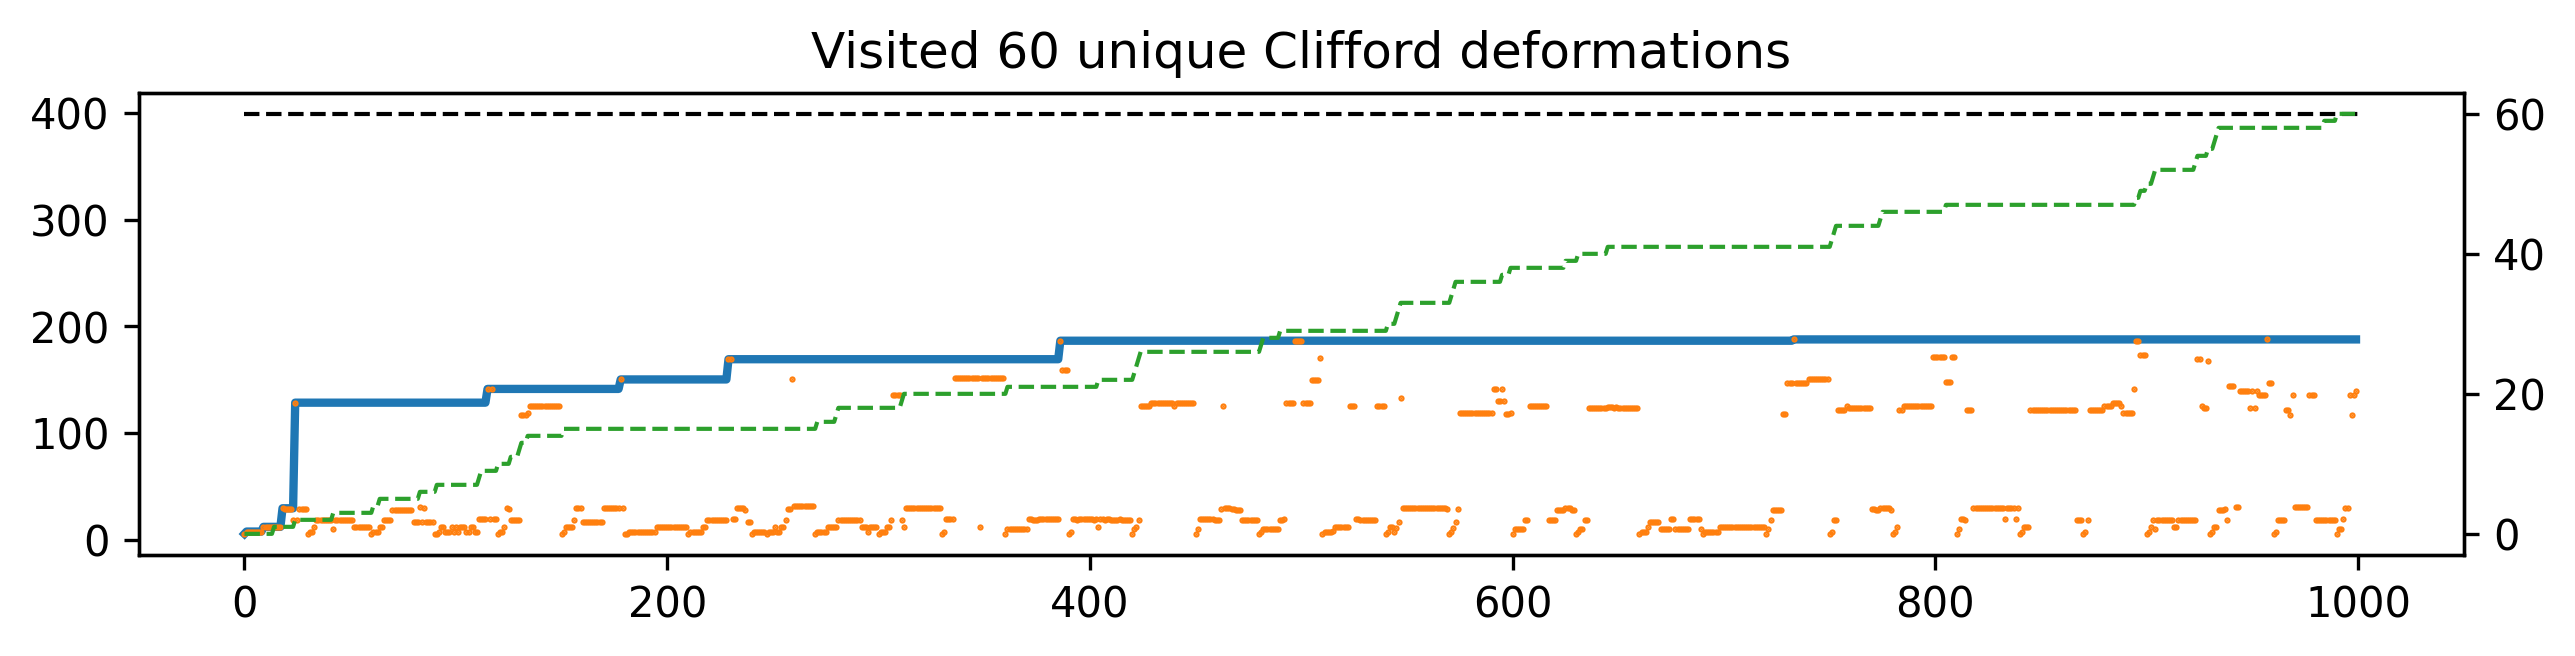

In [15]:
plt.figure(figsize=(10,2), dpi=300)
plt.plot(jnp.arange(all_scores.shape[0]), lax.cummax(all_scores), lw=2)
plt.plot(jnp.arange(all_scores.shape[0]), all_scores, '.', ms=1)
plt.hlines([398.99194], [0], [visited.shape[0]], ls='--', color='k', zorder=0, lw=1)
plt.title(f"Visited {deformations_visited.sum()} unique Clifford deformations")
plt.twinx().plot(jnp.arange(visited.shape[0]), visited, '--C2', lw=1)
plt.show()

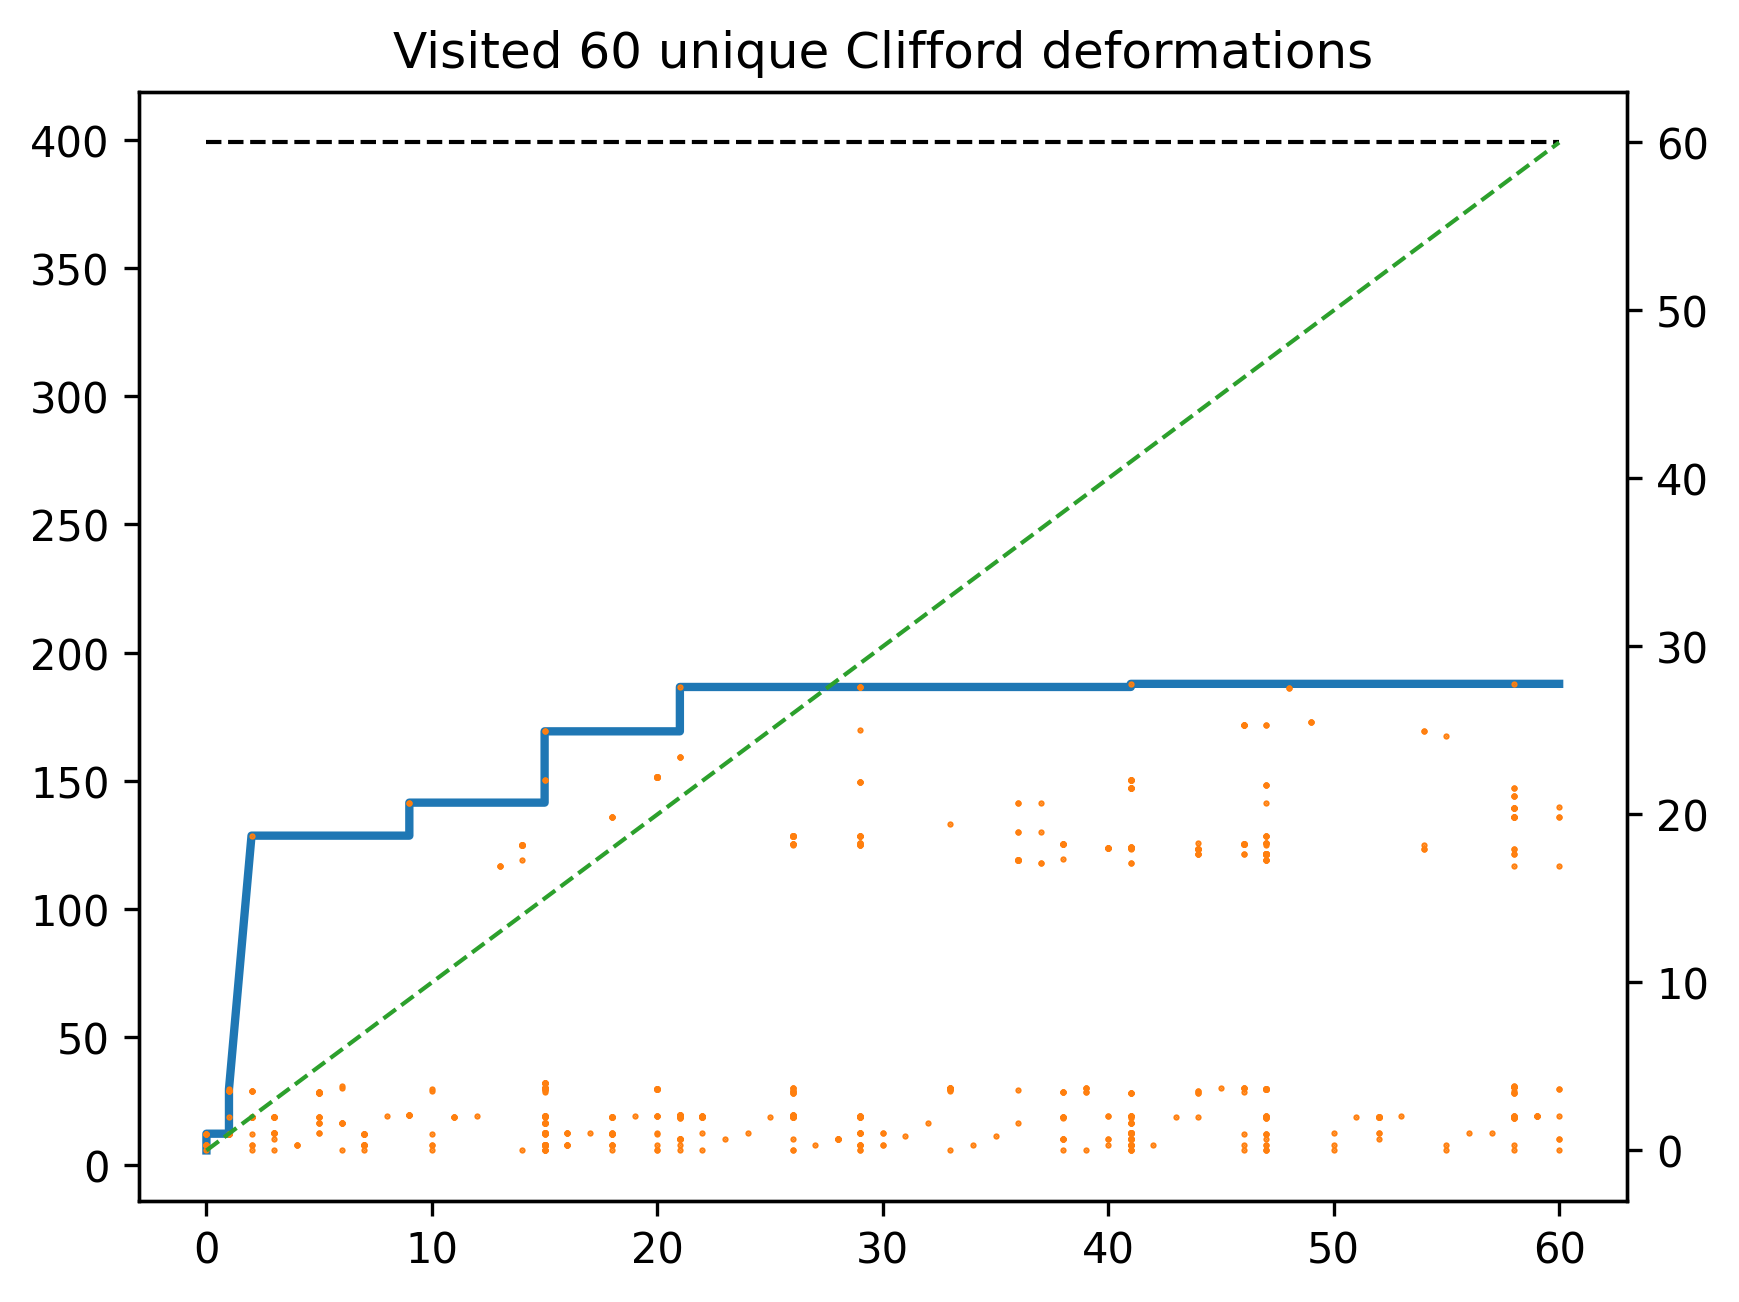

In [16]:
plt.figure(dpi=300)
plt.plot(visited, lax.cummax(all_scores), lw=2)
plt.plot(visited, all_scores, '.', ms=1)
plt.hlines([398.99194], [0], [visited.max()], ls='--', color='k', zorder=0, lw=1)
plt.title(f"Visited {deformations_visited.sum()} unique Clifford deformations")
plt.twinx().plot(visited, visited, '--C2', lw=1)
plt.show()

In [17]:
decay_rate=5E-2
success = 11
fail = 2

In [ ]:
decay_rate=1E-1
success = 7
fail = 6

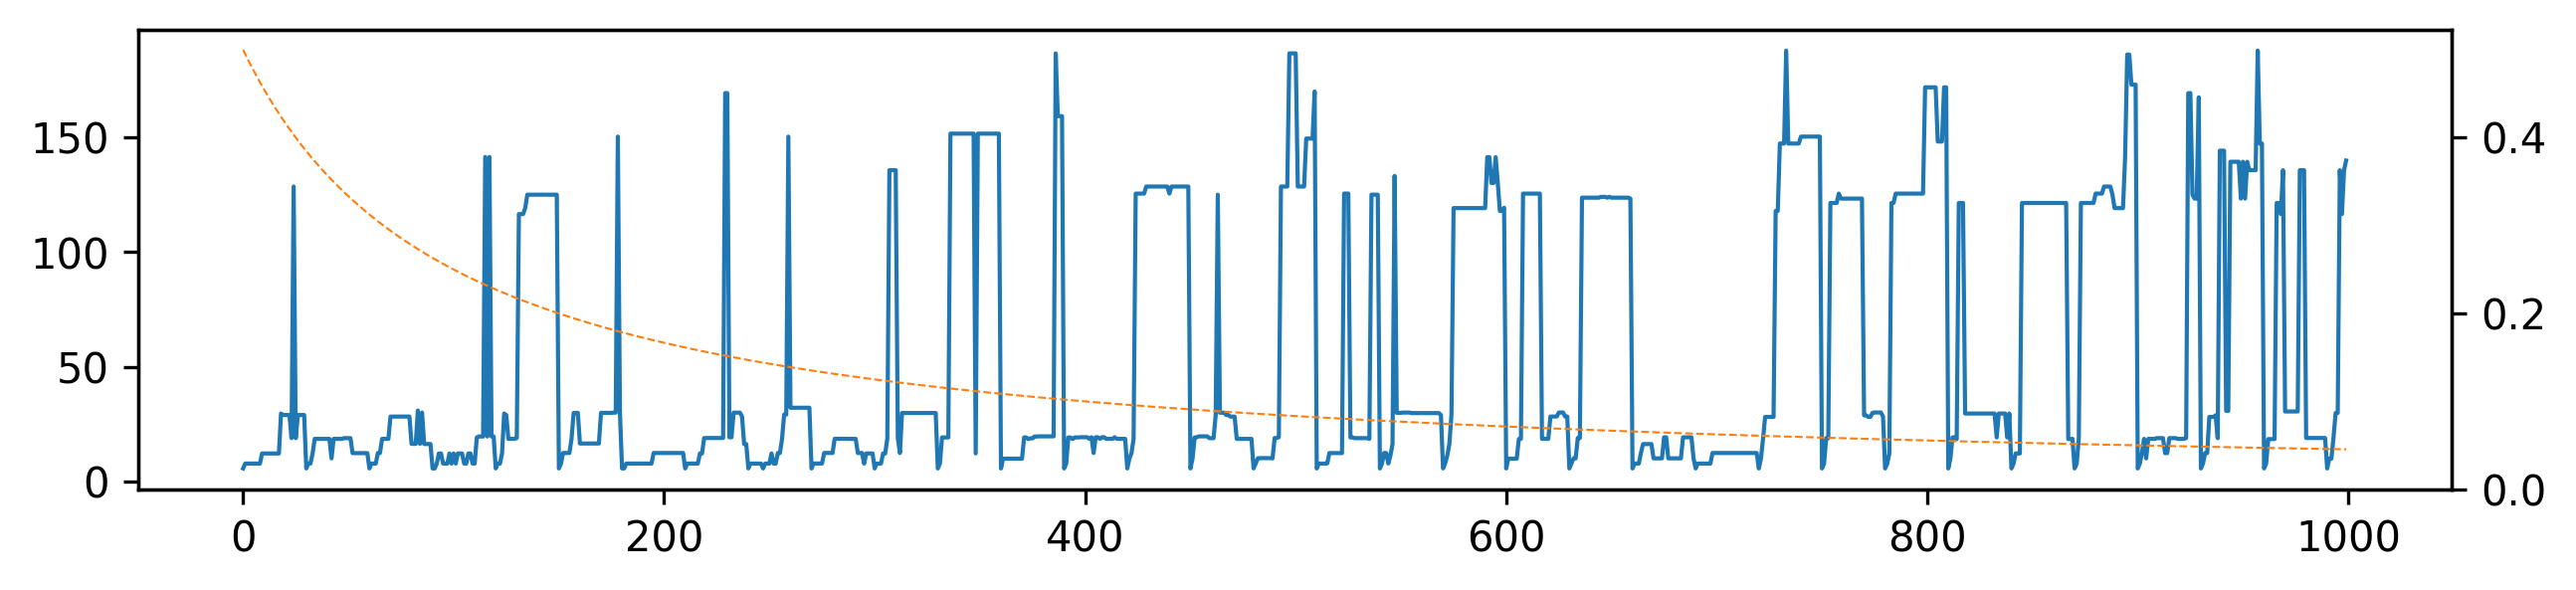

In [19]:
start = 0
width =  1_000
idx = jnp.arange(start, start+width)
plt.figure(figsize=(10,2), dpi=300)
plt.plot(idx, all_scores[idx], lw=1)
y2 = plt.twinx()
y2.plot(idx, inverse_scaling_decay(0.5, 0, idx, 1E-2), '--C1', lw=.5)
y2.set_ylim(ymin=0)
plt.show()

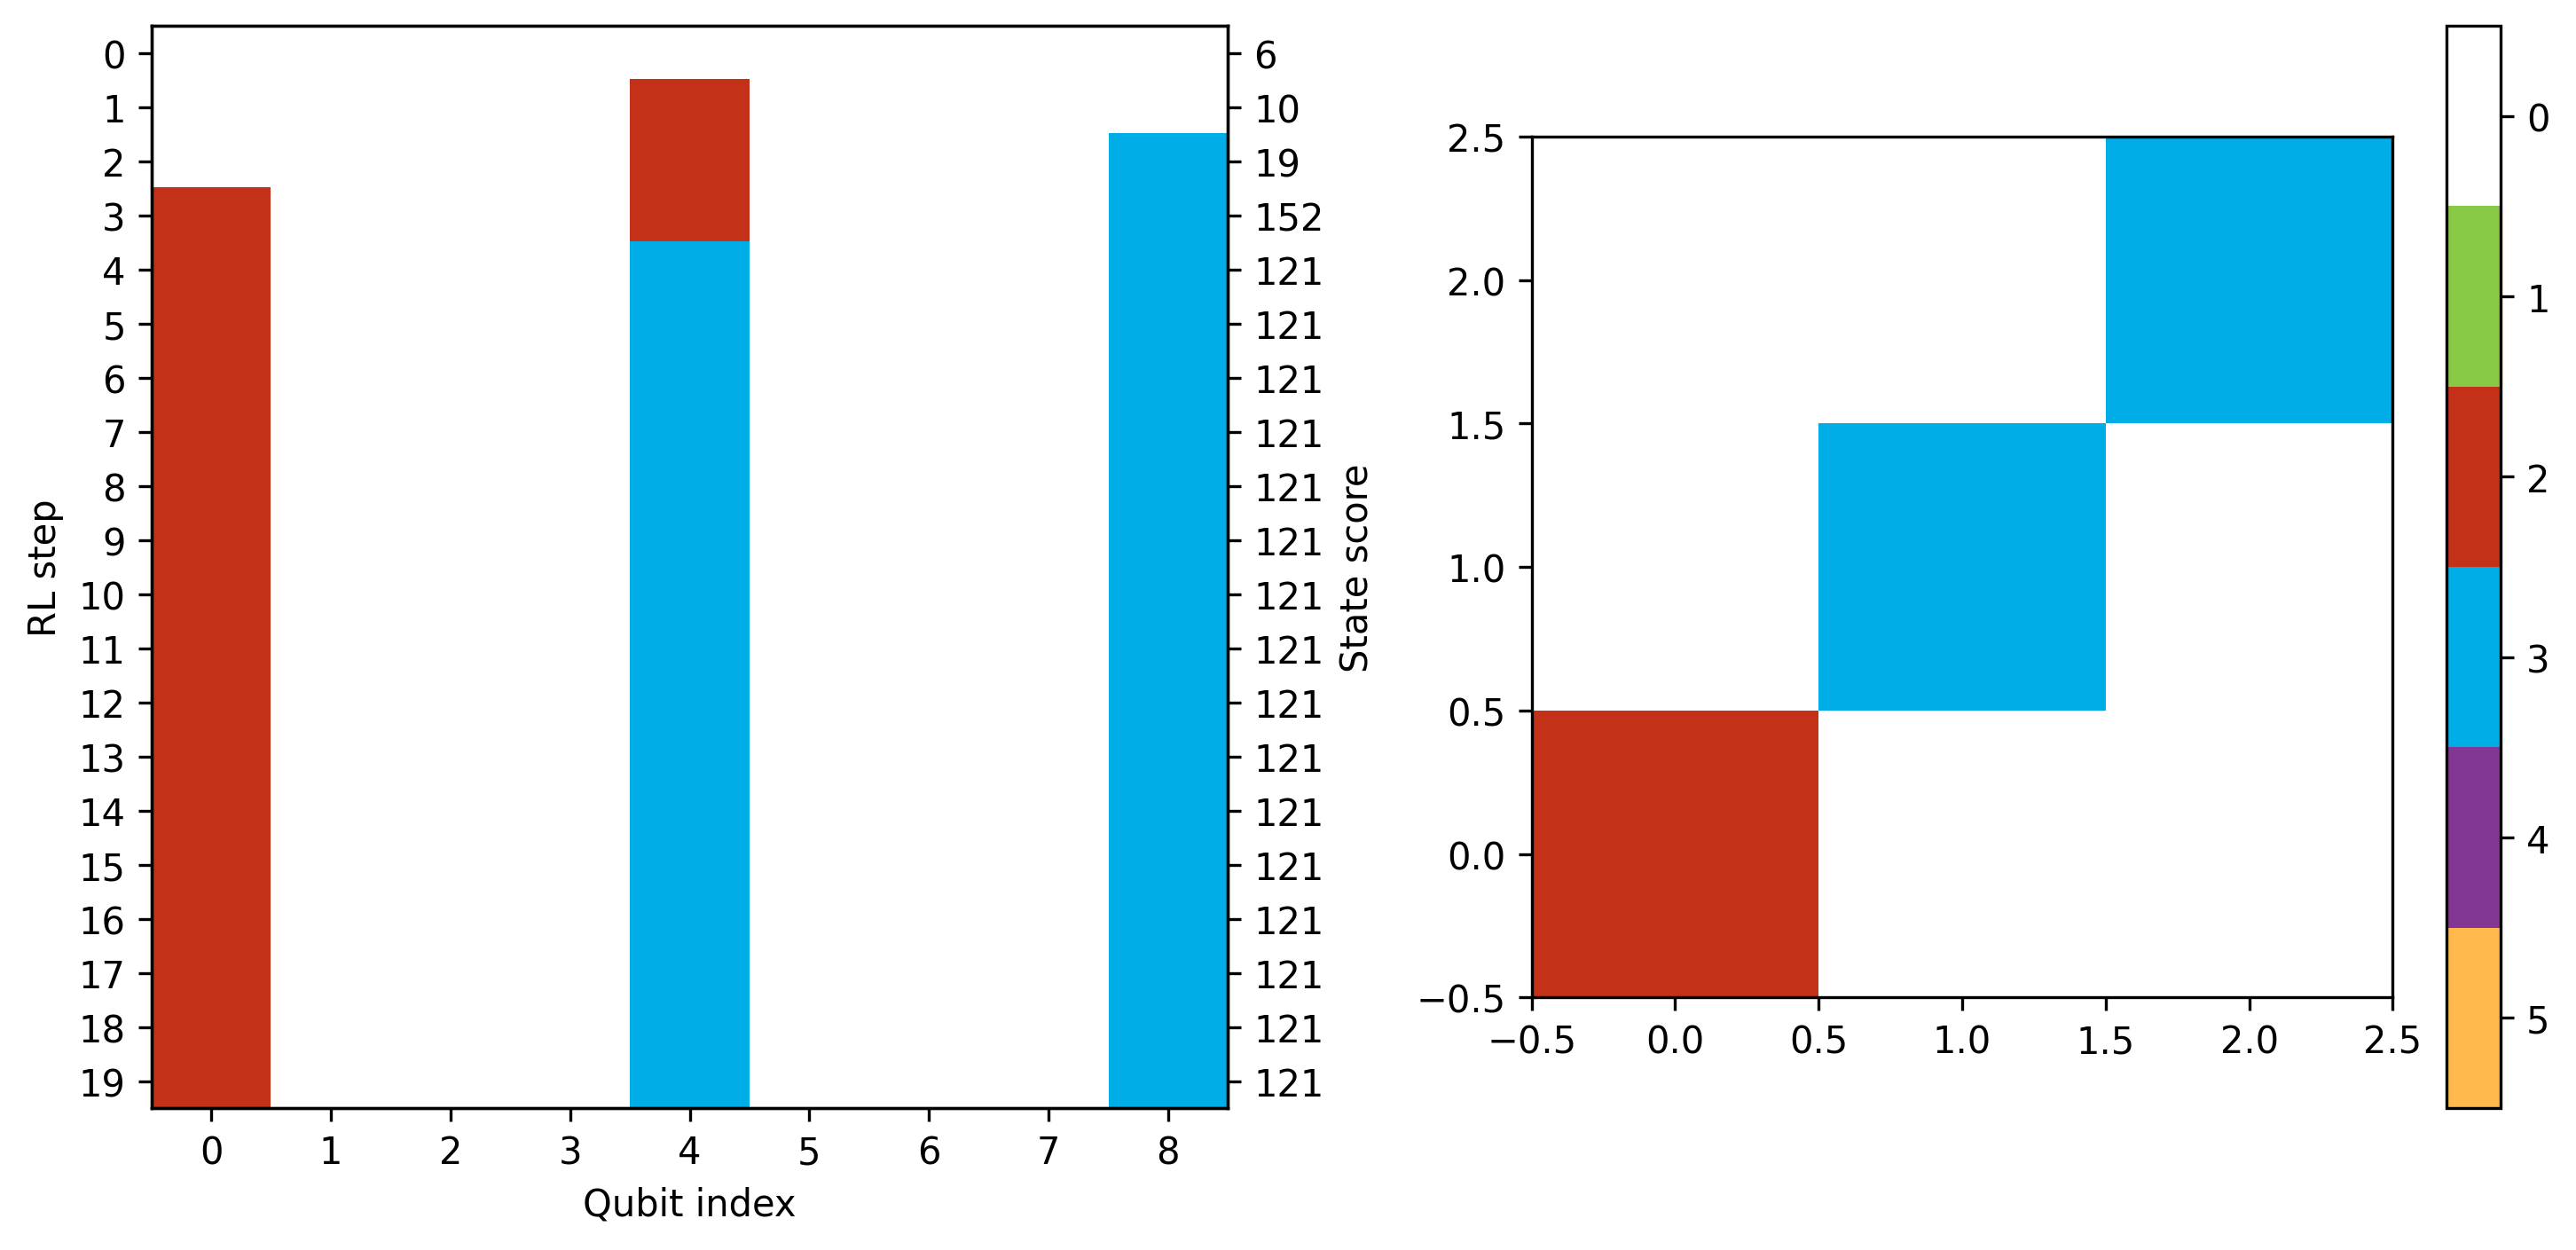

In [20]:
from matplotlib.colors import ListedColormap
deformation_cmap = ListedColormap([
    "#FFFFFF", # I
    "#88C946", # X-Y
    "#C43119", # Y-Z
    "#00ADE7", # X-Z
    "#833794", # X-Y-Z
    "#FFB94C", # X-Z-Y
])

steps = 20
state = jnp.zeros(shape=9, dtype=jnp.int32)
score = environment.score_state(state)
states = jnp.zeros(shape=(steps, state.shape[0]), dtype=jnp.int32)
scores = jnp.zeros(shape=(steps), dtype=jnp.float32)
for idx in range(steps-1):
    states = states.at[idx].set(state)
    scores = scores.at[idx].set(score)
    action, done, key = dqn_agent.act(
        key,
        model_params,
        state,
        epsilon=0 # Only follow policy
    )
    reward, score, new_state = environment.reward(
        current_score=score,
        current_state=state,
        action_idx=action
    )
    state = new_state
states = states.at[-1].set(state)
scores = scores.at[-1].set(score)

fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_figwidth(10)
fig.set_dpi(300)
a = ax1.imshow(states, vmin=-.5, vmax=5.5, cmap=deformation_cmap, aspect='auto', interpolation='nearest')
ax1.set_yticks(jnp.arange(steps))
y2 = ax1.twinx()
y2.set_yticks(jnp.arange(steps))
y2.set_yticklabels([f"{score:.0f}" for score in scores])
y2.set_ylim(ax1.get_ylim())
y2.set_ylabel("State score")
b = ax2.imshow(states[-1].reshape(3,3).T, vmin=-.5, vmax=5.5, cmap=deformation_cmap, aspect='equal', interpolation='nearest', origin='lower')
plt.colorbar(b).ax.invert_yaxis()
ax1.set_ylabel('RL step')
ax1.set_xlabel("Qubit index")
plt.tight_layout(h_pad=10)
plt.show()

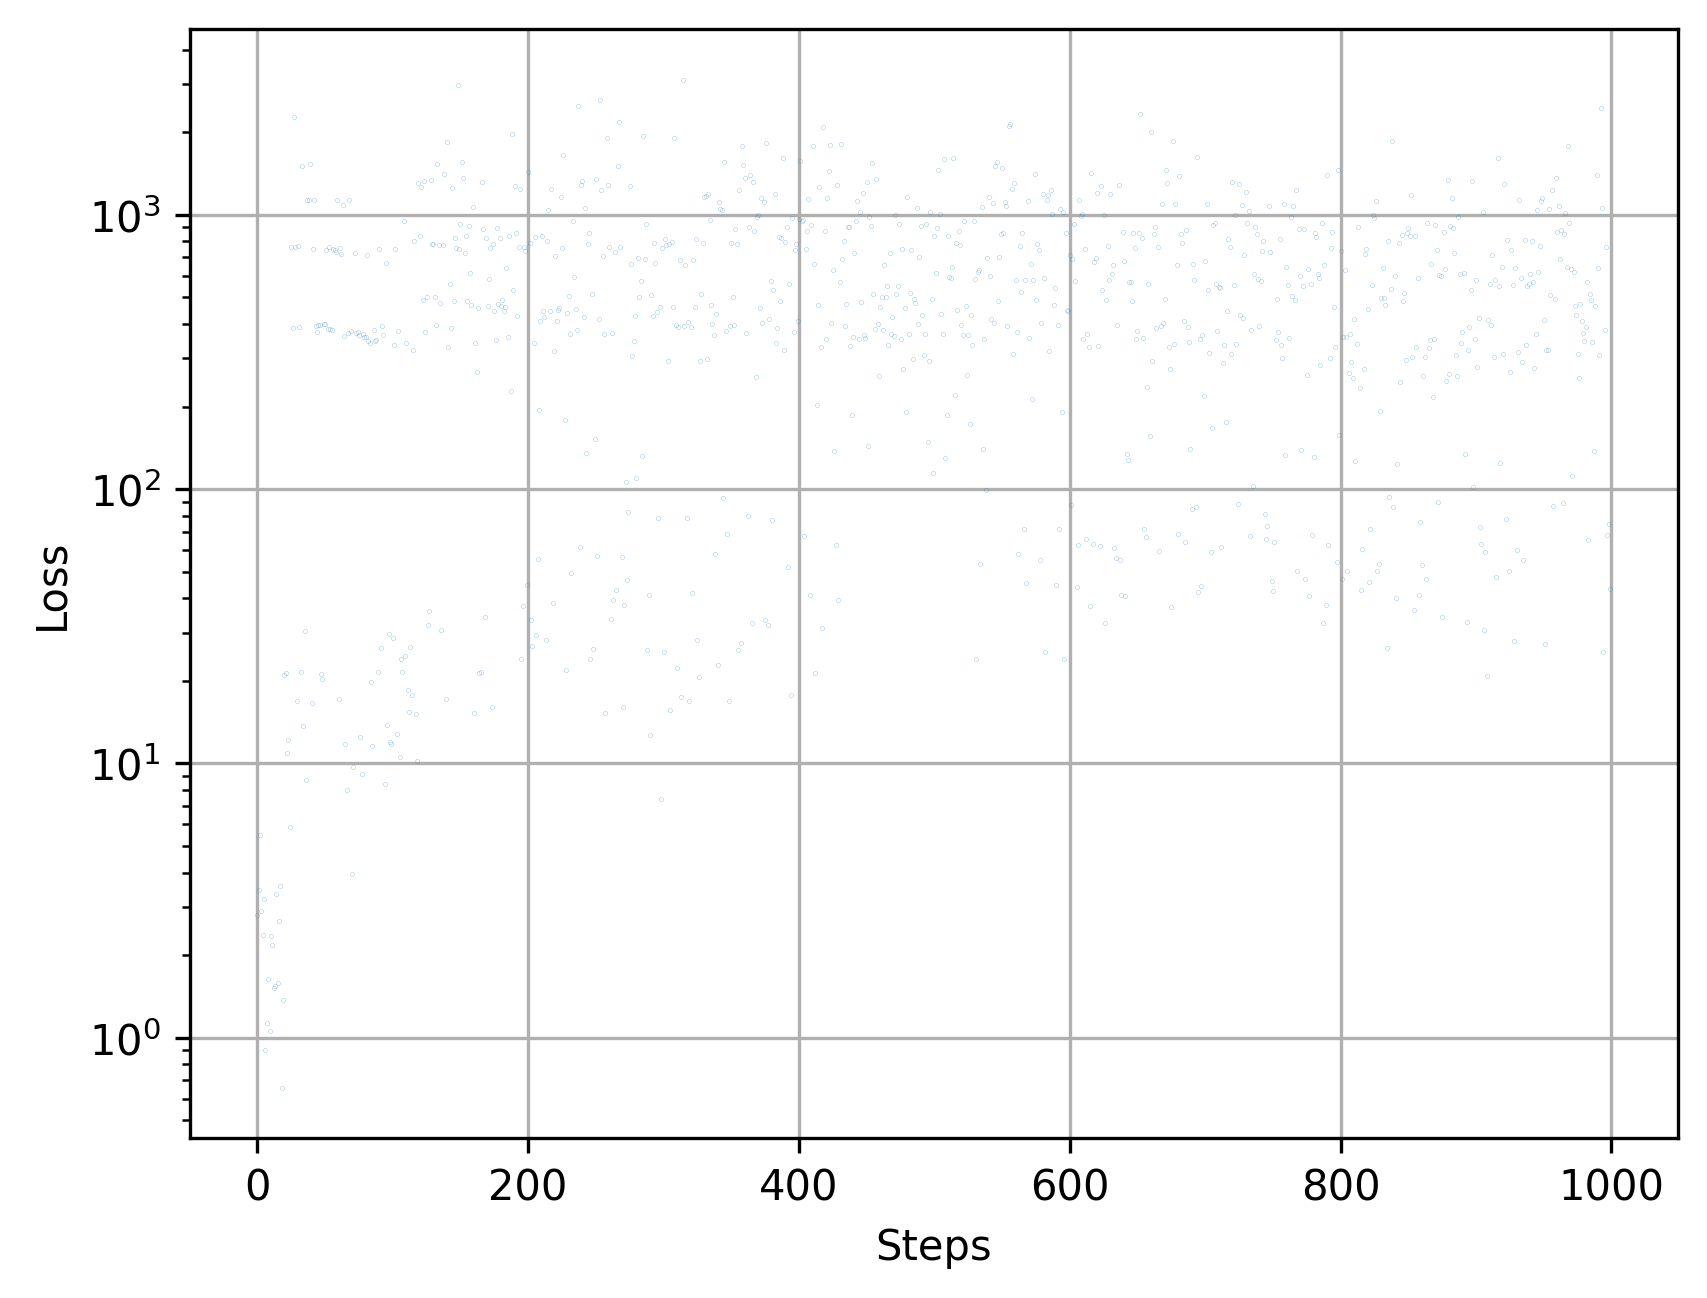

In [21]:
end = losses.shape[0]
plt.figure(dpi=300)
plt.plot(jnp.arange(end), losses, '.', lw=.5, ms=.1)
plt.grid()
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.yscale('log')
# plt.xlim(50000, 51000)
plt.show()